Changelog:  (Last Updated 2023-03-09)

# Probabilistic ML: Assignment 3
- **Deadline**: 2023-03-27 (March 27th 2023)
- **Submission**: You need to submit your solutions through MarkUs, including all your derivations, plots, and your code. You can produce the files however you like (e.g. $\LaTeX$, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.

# 1. [54pts] Stochastic Variational Inference in the TrueSkill Model

## Background

We'll continue working with [TrueSkill](http://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) model, a player ranking system for competitive games originally developed for Halo 2. Recall the model:


## Model definition

We assume that each player has a true, but unknown skill $z_i \in \mathbb{R}$.
We use $N$ to denote the number of players.

### The prior:
The prior over each player's skill is a standard normal distribution, and all player's skills are *a priori* independent.

### The likelihood:
For each observed game, the probability that player $i$ beats player $j$, given the player's skills $z_A$ and $z_B$, is:
$$p(A \,\, \text{beat} \,\, B | z_A, z_B) = \sigma(z_i - z_j)$$
where
$$\sigma(y) = \frac{1}{1 + \exp(-y)}$$
We chose this function simply because it's close to zero or one when the player's skills are very different, and equals one-half when the player skills are the same.  This likelihood function is the only thing that gives meaning to the latent skill variables $z_1 \dots z_N$.

There can be more than one game played between a pair of players. The outcome of each game is independent given the players' skills.
We use $M$ to denote the number of games.


In [ ]:
!pip install wget
import os
import os.path

import matplotlib.pyplot as plt
import wget

import pandas as pd


import numpy as np
from scipy.stats import norm
import scipy.io
import scipy.stats
import torch 
import random
from torch import nn
from torch.distributions.normal import Normal

from functools import partial
from tqdm import trange, tqdm_notebook

import matplotlib.pyplot as plt

# Helper function
def diag_gaussian_log_density(x, mu, std):
    # axis=-1 means sum over the last dimension.
    m = Normal(mu, std)
    return torch.sum(m.log_prob(x), axis=-1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9676 sha256=90a8e1fe9b21443ae37154f66e5c3a27466dd1233c6f64704c718efd1cd7c30e
  Stored in directory: /root/.cache/pip/wheels/04/5f/3e/46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


## Implementing the TrueSkill Model



This part was mostly done in Assignment 2. We will recall some useful functions.

**a)** The function $\texttt{log_joint_prior}$ computes the log of the prior, jointly evaluated over all player's skills.

In [ ]:
def log_joint_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

**b)** The function `logp_a_beats_b` that, given a pair of skills $z_a$ and $z_b$, evaluates the log-likelihood that player with skill $z_a$ beat player with skill $z_b$ under the model detailed above.

To ensure numerical stability, we use the function `np.log1p` that computes $\log(1 + x)$ in a numerically stable way.  Or even better, use `np.logaddexp`.

In [ ]:
def logp_a_beats_b(z_a, z_b):
    return -torch.logaddexp(torch.tensor([0.0]), z_b - z_a)

def log_prior_over_2_players(z1, z2):
    m = Normal(torch.tensor([0.0]), torch.tensor([[1.0]]))
    return m.log_prob(z1) + m.log_prob(z2)

def prior_over_2_players(z1, z2):
    return torch.exp(log_prior_over_2_players(z1, z2))

def log_posterior_A_beat_B(z1, z2):
    return log_prior_over_2_players(z1, z2) + logp_a_beats_b(z1, z2)

def posterior_A_beat_B(z1, z2):
    return torch.exp(log_posterior_A_beat_B(z1, z2))

def log_posterior_A_beat_B_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) + 10.0 * logp_a_beats_b(z1, z2)

def posterior_A_beat_B_10_times(z1, z2):
    return torch.exp(log_posterior_A_beat_B_10_times(z1, z2))

def log_posterior_beat_each_other_10_times(z1, z2):
    return log_prior_over_2_players(z1, z2) \
        + 10.* logp_a_beats_b(z1, z2) \
        + 10.* logp_a_beats_b(z2, z1)

def posterior_beat_each_other_10_times(z1, z2):
    return torch.exp(log_posterior_beat_each_other_10_times(z1, z2))

The following functions will be used for plotting.  Note that `plot_2d_fun` can now take an optional second function, so you can compare two functions.

In [ ]:
# Plotting helper functions for free
def plot_isocontours(ax, func, xlimits=[-4, 4], ylimits=[-4, 4], steps=101, cmap="summer"):
    x = torch.linspace(*xlimits, steps=steps)
    y = torch.linspace(*ylimits, steps=steps)
    X, Y = torch.meshgrid(x, y)
    Z = func(X, Y)
    plt.contour(X, Y, Z, cmap=cmap)
    ax.set_yticks([])
    ax.set_xticks([])

def plot_2d_fun(f, x_axis_label="", y_axis_label="", f2=None, scatter_pts=None):
    # This is the function your code should call.
    # f() should take two arguments.
    fig = plt.figure(figsize=(8,8), facecolor='white')
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel(y_axis_label)
    plot_isocontours(ax, f)
    if f2 is not None:
      plot_isocontours(ax, f2, cmap='winter')
    
    if scatter_pts is not None:
      plt.scatter(scatter_pts[:,0], scatter_pts[:, 1])
    plt.plot([4, -4], [4, -4], 'b--')   # Line of equal skill
    plt.show(block=True)
    plt.draw()

## **1.1 [20pts]** Stochastic Variational Inference on Two Players and Toy Data

One nice thing about a Bayesian approach is that it separates the model specification from the approximate inference strategy.
The original Trueskill paper from 2007 used message passing.

In this question we will  approximate posterior distributions with gradient-based stochastic variational inference.

The parameters are $\phi = (\mu,\log(\sigma))$. Notice that instead of $\sigma$ (which is constrained to be positive), we work with $\log(\sigma)$, removing the constraint. This way, we can do unconstrained gradient-based optimization.



**a) [9pts]** Implement the missing lines in the below code, to complete the evidence lower bound function and the reparameterized sampler for the approximate posterior.

Hint 1: You must use the reparametrization trick in your sampler if you want your gradients to be unbiased.

Hint 2: If you're worried you got these wrong, you can check that the sampler matches the log pdf by plotting a histogram of samples against a plot of the pdf.

In [ ]:
def diag_gaussian_samples(mean, log_std, num_samples):
    # mean and log_std are (D) dimensional vectors
    # Return a (num_samples, D) matrix, where each sample is
    # from a diagonal multivariate Gaussian.

    # TODO.  You might want to use torch.randn(). Remember
    # you must use the reparameterization trick.  Also remember that
    # we are parameterizing the _log_ of the standard deviation.

    D = mean.shape[0]
    return torch.randn(num_samples, D) * torch.exp(log_std) + mean


def diag_gaussian_logpdf(x, mean, log_std):
    # Evaluate the density of a batch of points on a 
    # diagonal multivariate Gaussian. x is a (num_samples, D) matrix.
    # Return a tensor of shape (num_samples)
    
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(logprob, mean, log_std, num_samples):
    # TODO: Use simple Monte Carlo to estimate ELBO
    # on a batch of size num_samples
    
    z = diag_gaussian_samples(mean, log_std, num_samples)
    logp_z = diag_gaussian_logpdf(z, mean, log_std)
    
    # monte carlo method: average across samples.
    elbo = torch.sum(logprob(z) - logp_z) / num_samples

    return elbo


**b) [4pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters, and returns an unbiased estimate of the negative elbo using $\texttt{num_samples_per_iter}$ samples, to approximate the joint posterior over skills conditioned on observing player A winning 10 games.

Note: We want a _negative_ ELBO estimate, because the convention in optimization is to minimize functions, and we want to maximize the ELBO.

In [ ]:
# Hyperparameters
num_players = 2
n_iters = 800
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_A_beat_B_10_times_1_arg(z1z2):
  return log_posterior_A_beat_B_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):  # The loss function to be minimized.
  # TODO.  Hint:  This can be done in one line.
  return -batch_elbo(log_posterior_A_beat_B_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**c) [1pts]** Initialize a set of variational parameters and optimize them to approximate the joint where we observe player A winning 10 games. Report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

Hint:  Almost initialization should be fine.  How many variational parameters do you need?

Optimizing variational parameters...


  4%|▍         | 31/800 [00:00<00:07, 103.07it/s]

Iteration 0 lower bound 8.187389373779297
Iteration 25 lower bound 6.528026103973389


  9%|▉         | 73/800 [00:00<00:04, 159.52it/s]

Iteration 50 lower bound 6.443575382232666
Iteration 75 lower bound 6.282167434692383


 22%|██▏       | 174/800 [00:00<00:02, 285.47it/s]

Iteration 100 lower bound 4.597244739532471
Iteration 125 lower bound 4.810819149017334
Iteration 150 lower bound 4.9488301277160645
Iteration 175 lower bound 4.1678385734558105


 27%|██▋       | 218/800 [00:01<00:01, 329.34it/s]

Iteration 200 lower bound 4.304173469543457
Iteration 225 lower bound 4.358727931976318


 32%|███▏      | 253/800 [00:01<00:02, 249.30it/s]

Iteration 250 lower bound 3.951963424682617


 39%|███▉      | 310/800 [00:01<00:02, 205.13it/s]

Iteration 275 lower bound 3.133211374282837
Iteration 300 lower bound 3.469719171524048
Iteration 325 lower bound 3.215118169784546


 53%|█████▎    | 422/800 [00:01<00:01, 301.37it/s]

Iteration 350 lower bound 2.886165142059326
Iteration 375 lower bound 3.0645055770874023
Iteration 400 lower bound 3.3895373344421387
Iteration 425 lower bound 2.974644184112549


 62%|██████▏   | 494/800 [00:02<00:00, 318.35it/s]

Iteration 450 lower bound 2.987278461456299
Iteration 475 lower bound 3.4557344913482666
Iteration 500 lower bound 2.799650192260742
Iteration 525 lower bound 3.1889071464538574


 70%|███████   | 562/800 [00:02<00:00, 284.29it/s]

Iteration 550 lower bound 3.1117143630981445
Iteration 575 lower bound 3.204859733581543


 81%|████████▏ | 650/800 [00:02<00:00, 243.78it/s]

Iteration 600 lower bound 2.9147229194641113
Iteration 625 lower bound 2.7799272537231445
Iteration 650 lower bound 2.8998160362243652


 89%|████████▉ | 710/800 [00:03<00:00, 256.48it/s]

Iteration 675 lower bound 3.155653715133667
Iteration 700 lower bound 2.9330358505249023
Iteration 725 lower bound 2.937269687652588


 96%|█████████▌| 764/800 [00:03<00:00, 210.27it/s]

Iteration 750 lower bound 2.8410277366638184
Iteration 775 lower bound 2.9585273265838623


100%|██████████| 800/800 [00:03<00:00, 224.36it/s]
/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


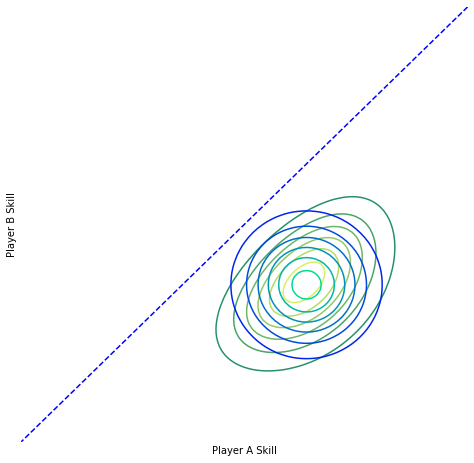

tensor([ 1.1134, -1.1112], requires_grad=True) tensor([-0.3534, -0.3511], requires_grad=True)


<Figure size 432x288 with 0 Axes>

In [ ]:
def callback(params, t):
  if t % 25 == 0:
    print("Iteration {} lower bound {}".format(t, objective(params)))

# Set up optimizer.
D = 2
init_log_std = torch.zeros(D, requires_grad=True)
init_mean = torch.zeros(D, requires_grad=True)

params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(params, t)


def approx_posterior_2d(z1, z2):
    # The approximate posterior
    mean, logstd = params[0].detach(), params[1].detach()
    return torch.exp(diag_gaussian_logpdf(torch.stack([z1, z2], dim=2), mean, logstd))

plot_2d_fun(posterior_A_beat_B_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

print(params[0], params[1])

**d) [3pts]** Write a loss function called $\texttt{objective}$  that takes variational distribution parameters , and returns a negative elbo estimate using simple Monte carlo with $\texttt{num_samples_per_iter}$ samples, to approximate the joint where we observe player A winning 10 games and player B winning 10 games.

Hint:  You can find analogous functions in the code above.


In [ ]:
# Hyperparameters
n_iters = 100
stepsize = 0.0001
num_samples_per_iter = 50

def log_posterior_beat_each_other_10_times_1_arg(z1z2):
    # z1z2 is a tensor with shape (num_samples x 2)
    # Return a tensor with shape (num_samples)

    return log_posterior_beat_each_other_10_times(z1z2[:,0], z1z2[:,1]).flatten()

def objective(params):
    return -batch_elbo(log_posterior_beat_each_other_10_times_1_arg, params[0], params[1], num_samples_per_iter)

**e) [3pts]** Run the code below to optimize, and report the final loss. Also plot the optimized variational approximation contours and the target distribution on the same axes.

---

Write one or two sentences describing the joint settings of skills that are plausible under the true posterior, but which are not plausible under the approximate posterior.

--- 

Finally, answer with one or two sentences:  Would changing the variational approximate posterior from a fully-factorized (diagonal covariance) Gaussian to a non-factorized (fully parameterized covariance) Gaussian make a better approximation in this instance?

Optimizing variational parameters...


  3%|▎         | 15/500 [00:00<00:03, 146.45it/s]

Iteration 0 lower bound 27.061861038208008
Iteration 25 lower bound 22.533580780029297


 19%|█▉        | 97/500 [00:00<00:02, 184.41it/s]

Iteration 50 lower bound 21.47174835205078
Iteration 75 lower bound 20.5174560546875


 29%|██▉       | 146/500 [00:00<00:01, 212.54it/s]

Iteration 100 lower bound 18.517927169799805
Iteration 125 lower bound 16.882802963256836


 39%|███▊      | 193/500 [00:01<00:01, 219.94it/s]

Iteration 150 lower bound 17.106822967529297
Iteration 175 lower bound 16.396886825561523


 48%|████▊     | 242/500 [00:01<00:01, 231.60it/s]

Iteration 200 lower bound 16.445138931274414
Iteration 225 lower bound 16.26719856262207


 58%|█████▊    | 291/500 [00:01<00:00, 230.76it/s]

Iteration 250 lower bound 15.728104591369629
Iteration 275 lower bound 16.150146484375


 67%|██████▋   | 337/500 [00:01<00:00, 203.28it/s]

Iteration 300 lower bound 15.905317306518555
Iteration 325 lower bound 15.893529891967773


 80%|████████  | 402/500 [00:01<00:00, 261.18it/s]

Iteration 350 lower bound 15.95683479309082
Iteration 375 lower bound 15.87903118133545
Iteration 400 lower bound 15.84546184539795


 93%|█████████▎| 464/500 [00:02<00:00, 282.31it/s]

Iteration 425 lower bound 16.165599822998047
Iteration 450 lower bound 15.981740951538086
Iteration 475 lower bound 15.399986267089844


100%|██████████| 500/500 [00:02<00:00, 223.03it/s]


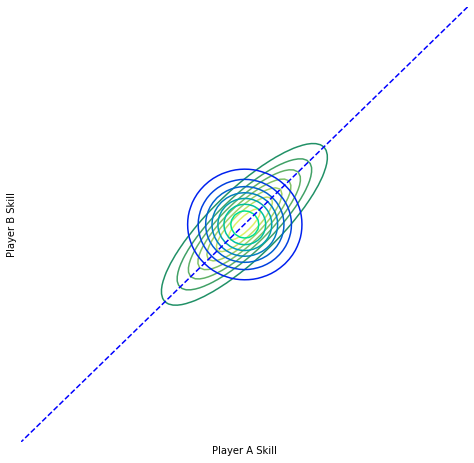

<Figure size 432x288 with 0 Axes>

In [ ]:
# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, 500):
    update()
    callback(params, t)

plot_2d_fun(posterior_beat_each_other_10_times, "Player A Skill", "Player B Skill",
            f2=approx_posterior_2d)

## 1.2 [34 pts] Approximate inference conditioned on real data 

The dataset contains data on 2546 chess games amongst 1434 players:
 - names is a 1434 by 1 matrix, whose $i$’th entry is the name of player $i$.
 - games is a 2546 by 2 matrix of game outcomes (actually chess matches), one row per game.

The first column contains the indices of the players who won.
The second column contains the indices of the player who lost.

It is based on the kaggle chess dataset: https://www.kaggle.com/datasets/datasnaek/chess




In [ ]:
wget.download("https://michalmalyska.github.io/csc412/chess_games.csv")
games = pd.read_csv("chess_games.csv")[["winner_index", "loser_index"]].to_numpy()
wget.download("https://michalmalyska.github.io/csc412/chess_players.csv")
names = pd.read_csv("chess_players.csv")[["index", "player_name"]].to_numpy()

games = torch.LongTensor(games)



**a) [0pt]** Assuming all game outcomes are i.i.d. conditioned on all players' skills, the function $\texttt{log_games_likelihood}$ takes a batch of player skills $\texttt{zs}$ and a collection of observed games $\texttt{games}$ and gives the total log-likelihood for all those observations given all the skills.


In [ ]:
def log_games_likelihood(zs, games):
    winning_player_ixs = games[:,0]
    losing_player_ixs = games[:,1]

    winning_player_skills = zs[:, winning_player_ixs] 
    losing_player_skills = zs[:, losing_player_ixs]

    log_likelihoods = logp_a_beats_b(winning_player_skills, losing_player_skills)
    return torch.sum(log_likelihoods, dim=1)

In [ ]:
def log_joint_probability(zs):
    return log_joint_prior(zs) + log_games_likelihood(zs, games)

**b) [4pt]** Write a new objective function like the one from the previous question. 

Below, we initialize a variational distribution and fit it to the joint distribution with all the observed tennis games from the dataset.

In [ ]:
# Hyperparameters
num_players = 1434
n_iters = 500
stepsize = 0.0001
num_samples_per_iter = 500

def objective(params):
  # objective is the ELBO for the joint probability and the proposal distribution
  # ELBO = E_{q(z)}[log(\frac{p(x,z)}{q(z)})]
  # after reparameterization
  # ELBO = E_{p(\epsilon)}[\logp(x, T(z,\phi,\epsilon)) - \logp(T(z,\phi,\epsilon))]

  # we reparameterize \epsilon \tilde N(0,1)
  #           \phi = (\mu, \log\sigma)
  #           \z  = T(\phi, \epsilon) = \mu + \epsilon * \exp{\log\sigma}

  return -batch_elbo(log_joint_probability, params[0], params[1], num_samples_per_iter)

**c) [3pts]** Optimize, and report the final loss. 

In [ ]:
# Set up optimizer.
init_mean = torch.zeros(num_players, requires_grad=True)
init_log_std  = torch.zeros(num_players, requires_grad=True)
params = (init_mean, init_log_std)
optimizer = torch.optim.SGD(params, lr=stepsize, momentum=0.9)

def update():
    optimizer.zero_grad()
    loss = objective(params)
    loss.backward()
    optimizer.step()

# Optimize and print loss in a loop
# HINT: you can use the callback() function to report loss
for t in range(num_samples_per_iter):
  update()
  callback(params, t)

Iteration 0 lower bound 2301.64208984375
Iteration 25 lower bound 2190.45166015625
Iteration 50 lower bound 2070.628173828125
Iteration 75 lower bound 1986.3857421875
Iteration 100 lower bound 1914.77197265625
Iteration 125 lower bound 1859.115234375
Iteration 150 lower bound 1816.4993896484375
Iteration 175 lower bound 1780.384521484375
Iteration 200 lower bound 1748.392822265625
Iteration 225 lower bound 1725.08984375
Iteration 250 lower bound 1700.978759765625
Iteration 275 lower bound 1684.9473876953125
Iteration 300 lower bound 1669.8585205078125
Iteration 325 lower bound 1652.6817626953125
Iteration 350 lower bound 1640.1397705078125
Iteration 375 lower bound 1630.0977783203125
Iteration 400 lower bound 1621.2257080078125
Iteration 425 lower bound 1613.2032470703125
Iteration 450 lower bound 1604.3096923828125
Iteration 475 lower bound 1598.9017333984375


**d) [1pt]** Plot the approximate mean and variance of all players, sorted by skill.

<ErrorbarContainer object of 3 artists>

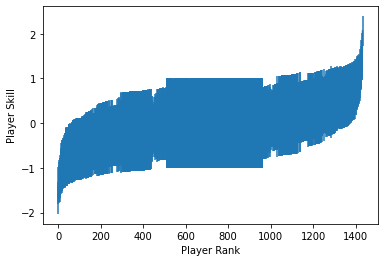

In [ ]:
# mean_skills, logstd_skills = # TODO.  Hint: You don't need to do simple Monte Carlo here.
# Hint: You should use .detach() before you do anything with the params tensors
mean_skills, logstd_skills = params[0].detach(), params[1].detach()
order = torch.argsort(mean_skills)

plt.xlabel("Player Rank")
plt.ylabel("Player Skill")
plt.errorbar(range(num_players), mean_skills[order], torch.square(torch.exp(logstd_skills[order])))

**e) [1pts]** List the names of the 10 players with the highest mean skill under the variational model.

In [ ]:
print("10 Highest skills: \n", names[order[-10:], 1][::-1])

10 Highest skills: 
 ['doraemon61' 'laode_syahril' 'projetoxadrez' 'mrzoom47' 'chesswithmom'
 'cdvh' 'hick4u1219' 'smartduckduckcow' 'sneaky_bugger' 'lzchips']


**f) [3pt]** Plot samples from the joint posterior over the skills of lelik3310 and thebestofthebad. Based on your samples, describe in a sentence the relationship between the skills of the players. (Is one better than the other? Are they approximately even?)

[496 'lelik3310']
[512 'thebestofthebad']


Text(0, 0.5, 'Player Skill')

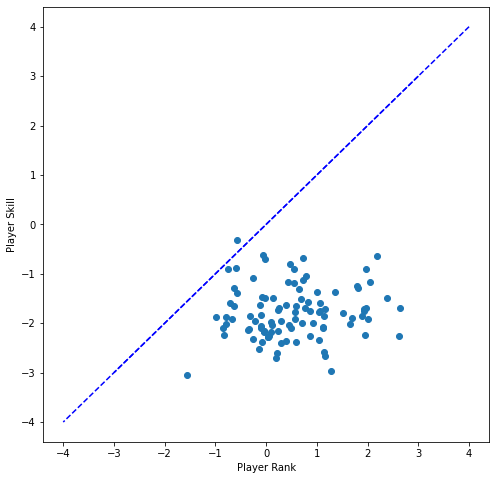

In [ ]:
lelik3310_ix = 496
thebestofthebad_ix = 512
print(names[lelik3310_ix])
print(names[thebestofthebad_ix])

fig = plt.figure(figsize=(8,8), facecolor='white')

# Label each with "<player> Skill"
plt.xlabel("lelik3310 Skill") 
plt.ylabel("thebestofthebad Skill") 

plt.plot([3, -3], [3, -3], 'b--') # Line of equal skill

samples = diag_gaussian_samples(mean_skills, logstd_skills, 100)

# TODO:  Hint:  Use plt.scatter()
smp = samples[:, (lelik3310_ix, thebestofthebad_ix)]
plt.scatter(x=smp[:,0], y=smp[:,1])
plt.plot([4, -4], [4, -4], 'b--')
plt.xlabel("Player Rank")
plt.ylabel("Player Skill")

**g) [8pts]** Derive the exact probability under a factorized Gaussian over two players’ skills that one has higher skill than the other, as a function of the two means and variances over their skills. Express your answer in terms of the cumulative distribution function of a one-dimensional Gaussian random variable.

- Hint 1: Use a linear change of variables $y_A, y_B = z_A − z_B , z_B$. What does the line of equal skill look like after this transformation?
- Hint 2: If $X \sim \mathcal N (\mu, \Sigma)$, then $AX \sim \mathcal N (A\mu, A\Sigma A^T)$ where $A$ is a linear transformation.
- Hint 3: Marginalization in Gaussians is easy: if $X \sim \mathcal N (\mu, \Sigma)$, then the $i$th element of $X$ has a
marginal distribution $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$.

First, we find the linear transformation matrix $A$ that changes variable $z_A$, $z_B$ to $y_A$, $y_B$.
$$
\begin{align}
A \cdot 
\begin{bmatrix}
z_A \\
z_B 
\end{bmatrix} &= 
\begin{bmatrix}
z_A-z_B \\
z_B 
\end{bmatrix} = 
\begin{bmatrix}
y_A \\
y_B 
\end{bmatrix}\\
A &= \begin{bmatrix}
1 & -1 \\
0 & 1 
\end{bmatrix}
\end{align}
$$
Then, we want to obtain a joint distribution $p(y_A,y_B)$. We know from the setup, $p(z_A, z_B) = \mathcal{N}(\mathbb{\mu}, \Sigma)$, $\mu = [\mu_A \;\; \mu_B]^T$, and since $z_A$ and $z_B$ are *a priori* independent, $\rho = Cov(z_A, z_B) = 0$, $$\Sigma = \begin{bmatrix}
\sigma_A^2 & \rho \sigma_A\sigma_B \\
\rho \sigma_B\sigma_A & \sigma_B^2 
\end{bmatrix}
= \begin{bmatrix}
\sigma_A^2 & 0 \\
0 & \sigma_B^2 
\end{bmatrix}
$$
 we apply this transformation to the mean vector and the covariance matrix of the joint distribution of $z_A$ and $z_B$, 

$$
\begin{align}
p(y_A, y_B) &= \mathcal{N}(\mu', \Sigma')\\
\mu'&=A\mu = \begin{bmatrix}
1 & -1 \\
0 & 1 
\end{bmatrix} \begin{bmatrix}
\mu_A \\
\mu_B 
\end{bmatrix}
= \begin{bmatrix}
\mu_A - \mu_B \\
\mu_B 
\end{bmatrix}\\
\Sigma' &= \begin{bmatrix}
1 & -1 \\
0 & 1 
\end{bmatrix}
\begin{bmatrix}
\sigma_A^2 & 0 \\
0 & \sigma_B^2 
\end{bmatrix}
\begin{bmatrix}
1 & -1 \\
0 & 1 
\end{bmatrix}^T
= \begin{bmatrix}
\sigma_A^2 + \sigma_B^2 & -\sigma_B^2 \\
-\sigma_B^2 & \sigma_B^2 
\end{bmatrix}
\end{align}
$$
After the transformation, the line of equal skills has changed from $z_A = z_B$ to $y_A = 0$. Therefore, the probability of one player is better than the other is the probability that $y_A$ is under the line of equality, i.e. 

$$
p(z_A > z_B) = p(y_A > 0) = 1 - p(y_A \leq 0)
$$

By Hint3, the marginalized probability $X_i \sim \mathcal N (\mu_i , \Sigma_{ii})$, then,

$$
\begin{align}
p(y_A) &= \mathcal{N}(\mu'_1, \Sigma'_{11})\\
&= \mathcal{N}(\mu_A - \mu_B, \sigma_A^2 + \sigma_B^2)\\
p(y_A > 0) &= 1-\Phi\left(\frac{0 - (\mu_A - \mu_B)}{\sqrt{\sigma_A^2 + \sigma_B^2}}\right)\\
&= 1-\Phi\left(\frac{\mu_B - \mu_A}{\sqrt{\sigma_A^2 + \sigma_B^2}}\right)
\end{align}
$$



**h) [4pts]** Compute the probability under your approximate posterior that lelik3310 has higher skill than thebestofthebad. Compute this quantity exactly using the formula you just derived above, and also estimate it using simple Monte Carlo with 10000 examples.

Hint:  You might want to use `Normal(0,1).cdf()` for the exact formula.

In [ ]:
# TODO
def prob_A_superior_B(N, A_ix, B_ix):
    mu_A, mu_B, sig_A, sig_B = mean_skills[A_ix], mean_skills[B_ix], torch.exp(logstd_skills[A_ix]), torch.exp(logstd_skills[B_ix])
    formula_est = 1 - Normal(0, 1).cdf((mu_B - mu_A) / (torch.sqrt(torch.square(sig_A) + torch.square(sig_B))))
    samples = diag_gaussian_samples(mean_skills, logstd_skills, N)
    mc_est = torch.sum(samples[:, A_ix] > samples[:, B_ix]) / N
    return formula_est, mc_est

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, thebestofthebad_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

Exact CDF Estimate: 0.9862385988235474
Simple MC Estimate: 0.9850000143051147


**i) [2pts]** Compute the probability that lelik3310 is better than the player with the 5th lowest mean skill. Compute this quantity exactly, and then estimate it using simple Monte Carlo with 10000 examples.


In [ ]:
# TODO
fifth_worst_ix = order[4]

formula_est, mc_est = prob_A_superior_B(10000, lelik3310_ix, fifth_worst_ix)
print(f"Exact CDF Estimate: {formula_est}")
print(f"Simple MC Estimate: {mc_est}")

# torch.where(order == lelik3310_ix), torch.where(order == thebestofthebad_ix), torch.where(order == fifth_worst_ix)

Exact CDF Estimate: 0.9621849656105042
Simple MC Estimate: 0.9617000222206116


**j) [4 pts]** Imagine that we knew ahead of time that we were examining the skills of top chess players, and so changed our prior on all players to Normal(10, 1) and re-ran our approximate inference from scratch. Would that change the answer of either of the previous 2 questions, in expectation?

No, it would not. It is because the posterior dominates the prior distribution.

**k) [4 pts]** Based on all the plots and results in this assignment and HW2, which approximate inference method do you suspect is producing a better overall approximation to the true posterior over all skills conditioned on all games?  Give a short explanation.

Your answer here.

MCMC is producing a better estimation. MCMC does not assume independence across samples while sampling in a Markov Chain.

# 2. [21pts] Question 2: VAE Warm up with synthetic data

In this question, we will train a VAE on a synthetic data which resembles spirals in 2d. This question is intended to provided you some debugging tools for the next question where you work on MNIST dataset. In both of the questions, we will perform amortized inference with VAEs.

Function below generates the synthetic spiral data.

In [ ]:
# Code to generate the pinwheel dataset.
# Taken from [Johnson et al (2016)], updated by Zhao & Linderman.
def make_pinwheel_data(radial_std, tangential_std, num_classes, num_per_class, rate):
    rads = torch.linspace(0, 2*torch.pi, num_classes + 1)

    features = torch.randn(num_classes*num_per_class, 2) * torch.tensor([radial_std, tangential_std])
    print(features)
    features[:, 0] = features[:, 0] + 1.0
    labels = torch.repeat_interleave(torch.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * torch.exp(features[:,0])
    rotations = torch.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
    rotations = torch.reshape(rotations.T, (-1, 2, 2))

    perm_ix = torch.randperm(labels.shape[0])
    return labels[perm_ix], torch.einsum('ti,tij->tj', features, rotations)[perm_ix]

We visualize the 2d data generated from the above function. Notice that there are 3 clusters in the input space, each colored with a different color. The VAE will not see the cluster assignments, but we hope to recover this structure in the latent space.

tensor([[-0.1122,  0.1020],
        [-0.0166,  0.1673],
        [-0.4299,  0.1123],
        ...,
        [-0.0024, -0.1673],
        [ 0.1258, -0.1396],
        [ 0.1804, -0.1212]])


(-1.7943063616752624,
 2.2595966696739196,
 -2.0792235136032104,
 1.4740592241287231)

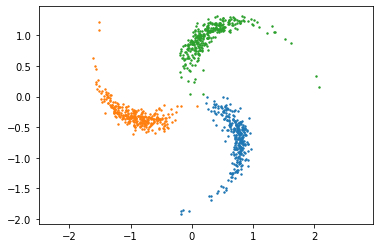

In [ ]:
num_clusters = 3           
samples_per_cluster = 300
labels, data = make_pinwheel_data(0.3, 0.1, num_clusters, samples_per_cluster, 0.25)

for k in range(num_clusters):
    plt.scatter(data[labels == k, 0], data[labels == k, 1], s=2)

plt.axis("equal")

## 2.1 [12 pts] Implement the missing lines in the below code, to complete the $\texttt{elbo}$ function for a variational autoencoder.

You can and should use the same code for both the spiral dataset and MNIST.  The spiral dataset and an example encoder / decoder is provided just to help you debug, and as a template for the MNIST VAE.


In [ ]:
# Generic VAE functions.

def log_prior(zs_array):
    return diag_gaussian_log_density(zs_array, torch.tensor([0.0]), torch.tensor([1.0]))

def diag_gaussian_samples(mean, log_std, num_samples):
    return mean + torch.exp(log_std) * torch.randn(num_samples, mean.shape[-1])

def diag_gaussian_logpdf(x, mean, log_std):
    return diag_gaussian_log_density(x, mean, torch.exp(log_std))


def batch_elbo(  # Simple Monte Carlo estimate of the variational lower bound.
    recognition_net,    # takes a batch of datapoints, outputs mean and log_std of size (batch_size x latent_dim), i.e. log q(z|x)
    decoder_net,        # takes a batch of latent samples, outputs mean and log_std of size (batch_size x data_dim), i.e. log p(x|z)
    log_joint,          # takes decoder_net, a batch of latent samples, and a batch of datapoints, outputs unnormalized log joint, i.e. log p(x,z)
    data                # a.k.a. x
    ):
    # TODO.  Get posterior parameters
    mean, log_std = recognition_net(data)
    assert mean.shape[0] == log_std.shape[0]
    N = mean.shape[0]
    
    # TODO.  Sample z from approximate posterior.
    z = diag_gaussian_samples(mean, log_std, N)

    # TODO.  Calculate the log joint logp(x_reconstruct, z)
    log_x_joint_z = log_joint(decoder_net, z, data)
    
    # TODO.  Calculate the log posterior logp(x_reconstruct | z)
    logq_z = diag_gaussian_logpdf(z, mean, log_std)
    log_posterior = log_x_joint_z - logq_z

    # TODO.  Produce an unbiased esimate of the ELBO.
    elbo = torch.sum(log_posterior) / N 

    return elbo #TODO: return monte carlo estimate

The below code trains a VAE where the encoder and decoder are both neural networks. The parameters are specified in the starter code.  You don't need to do anything here, this is just to help you debug.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
# Now define a specific VAE for the spiral dataset

data_dimension = 2
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension)

# Define the decoder network.
# Note that it has two outputs, a mean and a variance, because 
# this model has a Gaussian likelihood p(x|z).
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, data_dimension) # Output mean of p(x|z)
        self.std_net = nn.Linear(50, data_dimension) # Output log_std of p(x|z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

decoder_net = Decoder(latent_dimension, data_dimension)

# Set up log likelihood function.
def log_likelihood(decoder_net, latent, data):
    mean, log_std = decoder_net(latent)
    return diag_gaussian_logpdf(data, mean,
                                np.log(0.1) + 0. * log_std)  # Note: we are cheating here and using a fixed noise variance to make optimization more stable.

def log_joint(decoder_net, latent, data):
    return log_prior(latent) + log_likelihood(decoder_net, latent, data)

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-3)
n_iters = 2000
minibatch_size = 300

dataset = TensorDataset(torch.tensor(data))
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.
    minibatch = next(iter(dataloader))[0]
    return -batch_elbo(
    recognition_net,
    decoder_net,
    log_joint,
    minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

<ipython-input-23-122f2421a0a8>:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(data))


Optimizing variational parameters...


  0%|          | 8/2000 [00:00<00:25, 78.21it/s]

Iteration 0 lower bound -61.001373291015625


  6%|▋         | 127/2000 [00:00<00:12, 145.90it/s]

Iteration 100 lower bound -2.315244197845459


 11%|█         | 218/2000 [00:01<00:12, 143.05it/s]

Iteration 200 lower bound -1.8526833057403564


 16%|█▋        | 328/2000 [00:02<00:11, 140.41it/s]

Iteration 300 lower bound -1.673120379447937


 21%|██        | 411/2000 [00:03<00:14, 110.03it/s]

Iteration 400 lower bound -1.5523838996887207


 26%|██▌       | 511/2000 [00:04<00:17, 86.84it/s]

Iteration 500 lower bound -1.421325445175171


 31%|███       | 614/2000 [00:05<00:14, 95.29it/s]

Iteration 600 lower bound -1.307217001914978


 36%|███▋      | 729/2000 [00:06<00:09, 140.27it/s]

Iteration 700 lower bound -1.3025915622711182


 41%|████      | 821/2000 [00:06<00:08, 141.80it/s]

Iteration 800 lower bound -1.4995036125183105


 46%|████▌     | 915/2000 [00:07<00:07, 146.16it/s]

Iteration 900 lower bound -1.2245808839797974


 51%|█████     | 1022/2000 [00:08<00:06, 145.83it/s]

Iteration 1000 lower bound -1.2586698532104492


 56%|█████▋    | 1129/2000 [00:08<00:05, 145.50it/s]

Iteration 1100 lower bound -1.3461453914642334


 61%|██████    | 1220/2000 [00:09<00:05, 144.35it/s]

Iteration 1200 lower bound -1.1665371656417847


 66%|██████▋   | 1326/2000 [00:10<00:04, 146.30it/s]

Iteration 1300 lower bound -1.2269760370254517


 71%|███████   | 1416/2000 [00:10<00:04, 135.55it/s]

Iteration 1400 lower bound -1.1455992460250854


 76%|███████▌  | 1518/2000 [00:11<00:03, 133.85it/s]

Iteration 1500 lower bound -1.2467522621154785


 81%|████████  | 1621/2000 [00:12<00:02, 126.49it/s]

Iteration 1600 lower bound -1.3910629749298096


 86%|████████▋ | 1727/2000 [00:13<00:01, 144.89it/s]

Iteration 1700 lower bound -1.0797678232192993


 91%|█████████ | 1818/2000 [00:13<00:01, 144.51it/s]

Iteration 1800 lower bound -1.1593832969665527


 96%|█████████▌| 1924/2000 [00:14<00:00, 143.85it/s]

Iteration 1900 lower bound -1.1686877012252808


100%|██████████| 2000/2000 [00:15<00:00, 132.20it/s]


## 2.2 [5 pts]  In this part, we visualize how the data looks like in the latent space. We simply use the trained recognition network (the encoder) to map each input to latent space.


Text(0, 0.5, 'latent dimension 2')

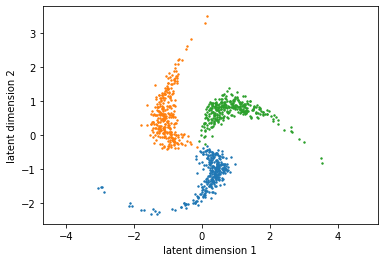

In [ ]:
# Show the means of the encoded data in a 2D latent space.
# Don't worry if this doesn't look much like a Gaussian.

for k in range(num_clusters):
    cur_data = data[labels == k, :] # TODO get all the data from this cluster.
    transformed = recognition_net(data[labels == k, :])[0].detach() # TODO find the mean of q(z|x) for each x. Remember to .detach() any tensors
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")
plt.xlabel("latent dimension 1")
plt.ylabel("latent dimension 2")

## 2.3 [4pts] Generate new data using the decoder and the generative model we just trained.

For this, we simply generate 1000 latent variables in the latent space from the prior and pass it through the decoder network.

You shouldn't expect this to match the data exactly, just to get the overall shape and number of clusters roughly correct.  


(-1.728698879480362,
 1.5943696796894073,
 -1.6535854578018188,
 1.5158219575881957)

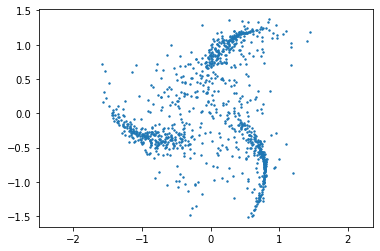

In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.  # Note: This doesn't add the likelihood noise,
# although it should if we want it to match the data.

num_samples = 1000

samples = torch.randn(num_samples, latent_dimension) # TODO
transformed = decoder_net(samples)[0].detach()

plt.scatter(transformed[:, 0], transformed[:, 1], s=2)
plt.axis("equal")

Here's a debugging tool only available when both the latent space and the data are both 2-dimensional.  We can show the function being learned by the encoder by showing how it warps a 2D grid into the latent space.

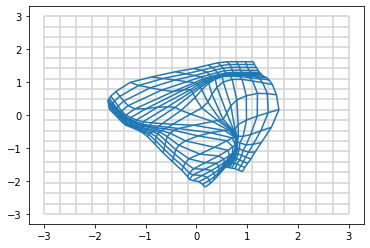

In [ ]:
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return decoder_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

Here, we show the function being learned by the decoder by showing how it warps a 2D grid into the observed space.



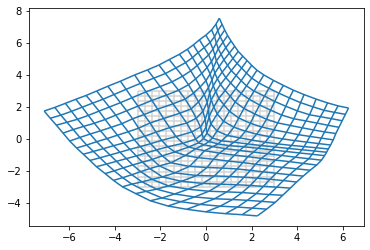

In [ ]:
def f(x,y):
    xy = torch.stack([x.flatten(), y.flatten()], dim=1)
    return recognition_net(xy)

fig, ax = plt.subplots()

grid_x,grid_y = torch.meshgrid(torch.linspace(-3,3,20),torch.linspace(-3,3,20))
plot_grid(grid_x,grid_y, ax=ax,  color="lightgrey")

distx, disty = f(grid_x,grid_y)
distx, disty = distx.reshape(20, 20, 2), disty.reshape(20, 20, 2)
plot_grid(distx[:, :, 0].detach().numpy(), distx[:, :, 1].detach().numpy(), ax=ax, color="C0")

plt.show()

#3. [34pts] Question 3: VAE Real Data

In this question, we will implement and investigate the Variational Autoencoder  as introduced by the paper [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) by Kingma and Welling (2013) on binarized fashion MNIST data.

The below code contains a function that downloads the fashion MNIST data set and another one that can plot multiple images.


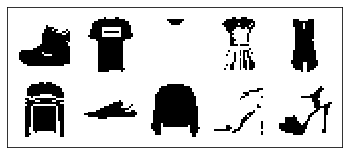

In [ ]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_images, test_images = np.float32(train_images), np.float32(test_images)
    train_labels = torch.tensor(one_hot(train_labels, 10))
    test_labels = torch.tensor(one_hot(test_labels, 10))
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()

def plot_images(images, ims_per_row=5, padding=5, dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((dimensions[0] + padding) * N_rows + padding,
                             (dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + dimensions[0]) * row_ix
        col_start = padding + (padding + dimensions[1]) * col_ix
        concat_images[row_start: row_start + dimensions[0],
                      col_start: col_start + dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()

plot_images(train_images[:10, :])

## 3.1 [15 pts] Implement the missing lines in the below code, and report the final ELBO

### The model is as follows:

*   **Prior:** The prior over each items's latent representation is a multivariate standard normal distribution. For all questions, we'll set the dimension of the latent space to 2.
A larger latent dimension would provide a more powerful model, but for this assignment we'll use a two-dimensional latent space to make visualization and debugging easier.


*   **Likelihood:** Given the latent representation $z$ for an image, the distribution over all 784 pixels in the image is given by a product of independent Bernoullis, whose means are given by the output of a neural network $f_\theta(z)$:
$$p(x|z, \theta) = \prod_{d=1}^{784} \operatorname{Ber}(x_d|f_\theta(z)_d)$$
The neural network $f_\theta$ is called the decoder, and its parameters $\theta$ will be optimized to fit the data.

### the functions to complete:
1.   $\texttt{log_likelihood}$: Log-likelihood of the above model.
2.   $\texttt{log_joint}$: Joint log-likelihood of data and latent variables.
3.   $\texttt{objective}$: You will use the elbo function you wrote in the previous question.

### Report the final ELBO. 

In [ ]:
 
 # Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 2

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension) # TODO: What are the input and output dimensions of the encoder?

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, data_dimension) # TODO: Output logit of Ber(x|z)
        )

    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension, data_dimension) # TODO: What are the input and output dimensions of the decoder?

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): # TODO
    return bernoulli_logpdf(decoder_net(latent), data)

def log_joint(decoder_net, latent, data): # TODO
    return log_likelihood(decoder_net, latent, data) + diag_gaussian_log_density(latent, torch.tensor([0.0]), torch.tensor([1.0]))

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))[0]

    return -batch_elbo(recognition_net,       # TODO
                        decoder_net,
                        log_joint,
                        minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 5/5000 [00:00<01:41, 49.38it/s]

Iteration 0 lower bound -533.0540771484375


  2%|▏         | 109/5000 [00:01<01:25, 57.13it/s]

Iteration 100 lower bound -210.05538940429688


  4%|▍         | 209/5000 [00:03<01:22, 58.14it/s]

Iteration 200 lower bound -205.0654296875


  6%|▌         | 312/5000 [00:05<01:23, 56.13it/s]

Iteration 300 lower bound -194.3584442138672


  8%|▊         | 407/5000 [00:07<01:54, 40.03it/s]

Iteration 400 lower bound -191.51988220214844


 10%|█         | 509/5000 [00:09<01:20, 55.69it/s]

Iteration 500 lower bound -194.96371459960938


 12%|█▏        | 609/5000 [00:11<01:16, 57.45it/s]

Iteration 600 lower bound -192.22230529785156


 14%|█▍        | 709/5000 [00:13<01:16, 56.01it/s]

Iteration 700 lower bound -183.03736877441406


 16%|█▌        | 809/5000 [00:15<01:25, 49.12it/s]

Iteration 800 lower bound -180.90283203125


 18%|█▊        | 908/5000 [00:17<01:22, 49.76it/s]

Iteration 900 lower bound -192.32615661621094


 20%|██        | 1009/5000 [00:19<01:23, 47.75it/s]

Iteration 1000 lower bound -178.50306701660156


 22%|██▏       | 1105/5000 [00:21<01:51, 34.93it/s]

Iteration 1100 lower bound -182.45672607421875


 24%|██▍       | 1208/5000 [00:23<01:16, 49.83it/s]

Iteration 1200 lower bound -182.8074188232422


 26%|██▌       | 1309/5000 [00:25<01:10, 52.08it/s]

Iteration 1300 lower bound -173.46546936035156


 28%|██▊       | 1408/5000 [00:28<01:13, 48.69it/s]

Iteration 1400 lower bound -171.47244262695312


 30%|███       | 1510/5000 [00:30<01:07, 51.57it/s]

Iteration 1500 lower bound -186.01722717285156


 32%|███▏      | 1606/5000 [00:32<01:10, 48.09it/s]

Iteration 1600 lower bound -183.77464294433594


 34%|███▍      | 1708/5000 [00:34<01:28, 37.14it/s]

Iteration 1700 lower bound -188.28042602539062


 36%|███▌      | 1807/5000 [00:36<01:00, 53.04it/s]

Iteration 1800 lower bound -179.65359497070312


 38%|███▊      | 1909/5000 [00:38<01:00, 51.21it/s]

Iteration 1900 lower bound -172.2910614013672


 40%|████      | 2011/5000 [00:40<00:58, 50.77it/s]

Iteration 2000 lower bound -169.97103881835938


 42%|████▏     | 2107/5000 [00:42<00:54, 52.63it/s]

Iteration 2100 lower bound -179.91754150390625


 44%|████▍     | 2209/5000 [00:44<00:53, 51.98it/s]

Iteration 2200 lower bound -171.2216339111328


 46%|████▌     | 2305/5000 [00:46<01:16, 35.36it/s]

Iteration 2300 lower bound -191.51046752929688


 48%|████▊     | 2410/5000 [00:49<00:51, 49.92it/s]

Iteration 2400 lower bound -167.40994262695312


 50%|█████     | 2512/5000 [00:51<00:46, 53.03it/s]

Iteration 2500 lower bound -177.61492919921875


 52%|█████▏    | 2608/5000 [00:52<00:46, 51.05it/s]

Iteration 2600 lower bound -177.5791778564453


 54%|█████▍    | 2710/5000 [00:54<00:43, 52.34it/s]

Iteration 2700 lower bound -176.07691955566406


 56%|█████▌    | 2806/5000 [00:56<00:42, 51.12it/s]

Iteration 2800 lower bound -167.6566619873047


 58%|█████▊    | 2906/5000 [00:58<00:50, 41.35it/s]

Iteration 2900 lower bound -166.45562744140625


 60%|██████    | 3006/5000 [01:01<00:53, 37.55it/s]

Iteration 3000 lower bound -165.51193237304688


 62%|██████▏   | 3108/5000 [01:03<00:36, 52.32it/s]

Iteration 3100 lower bound -184.28538513183594


 64%|██████▍   | 3210/5000 [01:05<00:33, 53.81it/s]

Iteration 3200 lower bound -184.07977294921875


 66%|██████▌   | 3306/5000 [01:06<00:33, 50.43it/s]

Iteration 3300 lower bound -179.33425903320312


 68%|██████▊   | 3408/5000 [01:08<00:30, 51.60it/s]

Iteration 3400 lower bound -166.16436767578125


 70%|███████   | 3510/5000 [01:10<00:29, 50.01it/s]

Iteration 3500 lower bound -170.83448791503906


 72%|███████▏  | 3605/5000 [01:13<00:41, 33.90it/s]

Iteration 3600 lower bound -172.38037109375


 74%|███████▍  | 3708/5000 [01:15<00:26, 49.68it/s]

Iteration 3700 lower bound -169.18435668945312


 76%|███████▌  | 3806/5000 [01:18<00:38, 30.64it/s]

Iteration 3800 lower bound -173.20164489746094


 78%|███████▊  | 3910/5000 [01:20<00:21, 49.97it/s]

Iteration 3900 lower bound -174.71542358398438


 80%|████████  | 4005/5000 [01:22<00:22, 44.67it/s]

Iteration 4000 lower bound -170.87469482421875


 82%|████████▏ | 4107/5000 [01:25<00:25, 35.47it/s]

Iteration 4100 lower bound -176.18292236328125


 84%|████████▍ | 4209/5000 [01:27<00:16, 47.37it/s]

Iteration 4200 lower bound -170.04653930664062


 86%|████████▌ | 4311/5000 [01:29<00:14, 49.11it/s]

Iteration 4300 lower bound -176.93399047851562


 88%|████████▊ | 4406/5000 [01:31<00:11, 50.80it/s]

Iteration 4400 lower bound -176.17710876464844


 90%|█████████ | 4508/5000 [01:33<00:09, 51.78it/s]

Iteration 4500 lower bound -187.72866821289062


 92%|█████████▏| 4610/5000 [01:35<00:07, 51.10it/s]

Iteration 4600 lower bound -161.23406982421875


 94%|█████████▍| 4705/5000 [01:37<00:06, 43.27it/s]

Iteration 4700 lower bound -178.20201110839844


 96%|█████████▌| 4806/5000 [01:40<00:05, 36.63it/s]

Iteration 4800 lower bound -171.0858154296875


 98%|█████████▊| 4906/5000 [01:42<00:01, 50.87it/s]

Iteration 4900 lower bound -185.67950439453125


100%|██████████| 5000/5000 [01:44<00:00, 47.97it/s]


Iteration 5000 lower bound -177.8291778564453


## 3.2 [3pts]
 
In what follows, we will investigate our model by visualizing the distribution over data given by the generative model, sampling from it, and interpolating between items.

One way to understand the meaning of latent representations is to see which parts of the latent space correspond to which kinds of data. Here we'll produce a scatter plot in the latent space, where each point in the plot represents a different image in the training set.

Implement the missing lines in the below code, to plot the transformed data points in the latent space.



1.   Encode each image in the training set.
2.   Take the 2D mean vector of each encoding $q_\phi(z|x)$.
3.   Plot these mean vectors in the 2D latent space with a scatterplot.
4.   Colour each point according to the class label (0 to 9).


Hopefully our latent space will group images of different classes, even though we never provided class labels to the model!





(-3.333996021747589, 2.6056618332862853, -3.221477246284485, 3.606456971168518)

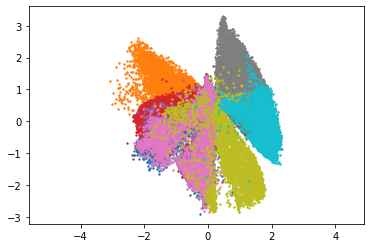

In [ ]:
for k in range(10):
    cur_data = torch.tensor(train_images[train_labels[:, k] == True, :]).to(torch.float32)
    transformed = recognition_net(cur_data)[0].detach() # TODO:  Call recognition net and extract mean, remember to .detach() the tensors!
    plt.scatter(transformed[:, 0], transformed[:, 1], s=2)

plt.axis("equal")

## 3.3 [8 pts] 
Now we'll fit a model with a larger latent space.  We won't be able to visualize this model as easily, but it should be able to fit the data better.  Set latent_dimension to 20 and re-fit the model.  You should be able to get a better ELBO using this larger model.

In [ ]:
 # Define a specific VAE for MNIST

data_dimension = 28*28
latent_dimension = 20

# Define the recognition network.
class RecognitionNet(nn.Module):
    def __init__(self, data_dimension, latent_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU()
        )
        self.mean_net = nn.Linear(50, latent_dimension) # Output mean of q(z)
        self.std_net = nn.Linear(50, latent_dimension) # Output log_std of q(z)
        
    def forward(self, x):
        interm = self.net(x)
        mean, log_std = self.mean_net(interm), self.std_net(interm)
        return mean, log_std

recognition_net = RecognitionNet(data_dimension, latent_dimension) # TODO: What are the input and output dimensions of the encoder?

# Define the decoder network.
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dimension, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.ReLU(),
            nn.Linear(50, data_dimension) # TODO: Output logit of Ber(x|z)
        )

    def forward(self, x):
        return self.net(x)

decoder_net = Decoder(latent_dimension, data_dimension) # TODO: What are the input and output dimensions of the decoder?

# Set up log likelihood function.
def bernoulli_logpdf(logits, x):
    """Bernoulli log pdf of data x given logits."""
    return -torch.sum(torch.logaddexp(torch.tensor([0.]), torch.where(x > 0.5, -1., 1.) * logits), dim=1)

def log_likelihood(decoder_net, latent, data): # TODO
    return bernoulli_logpdf(decoder_net(latent), data)

def log_joint(decoder_net, latent, data): # TODO
    return log_likelihood(decoder_net, latent, data) + diag_gaussian_log_density(latent, torch.tensor([0.0]), torch.tensor([1.0]))

# Run optimization
optimizer = torch.optim.Adam([{'params': recognition_net.parameters()},
                      {'params': decoder_net.parameters()}], lr=1e-2)
n_iters = 5000
minibatch_size = 200

dataset = TensorDataset(torch.tensor(train_images), )
dataloader = DataLoader(dataset, batch_size=minibatch_size, shuffle=True)

def objective(recognition_net, decoder_net):  # The loss function to be minimized.  
    minibatch = next(iter(dataloader))[0]

    return -batch_elbo(recognition_net,       # TODO
                        decoder_net,
                        log_joint,
                        minibatch)

def callback(t):
    if t % 100 == 0:
        print("Iteration {} lower bound {}".format(t, -objective(recognition_net, decoder_net)))

def update():
    optimizer.zero_grad()
    loss = objective(recognition_net, decoder_net)
    loss.backward()
    optimizer.step()

# Main loop.
print("Optimizing variational parameters...")
for t in trange(0, n_iters):
    update()
    callback(t)

callback(n_iters)

Optimizing variational parameters...


  0%|          | 6/5000 [00:00<01:34, 52.86it/s]

Iteration 0 lower bound -547.4089965820312


  2%|▏         | 111/5000 [00:02<01:27, 56.09it/s]

Iteration 100 lower bound -221.9167938232422


  4%|▍         | 211/5000 [00:03<01:25, 55.93it/s]

Iteration 200 lower bound -195.44699096679688


  6%|▌         | 306/5000 [00:05<01:59, 39.36it/s]

Iteration 300 lower bound -174.1513671875


  8%|▊         | 409/5000 [00:08<01:22, 55.42it/s]

Iteration 400 lower bound -171.58572387695312


 10%|█         | 507/5000 [00:09<01:21, 54.91it/s]

Iteration 500 lower bound -166.84104919433594


 12%|█▏        | 612/5000 [00:11<01:17, 56.85it/s]

Iteration 600 lower bound -153.36163330078125


 14%|█▍        | 709/5000 [00:13<01:18, 54.74it/s]

Iteration 700 lower bound -158.38182067871094


 16%|█▌        | 810/5000 [00:15<01:30, 46.47it/s]

Iteration 800 lower bound -160.2445526123047


 18%|█▊        | 905/5000 [00:17<01:50, 37.12it/s]

Iteration 900 lower bound -149.7957305908203


 20%|██        | 1008/5000 [00:20<01:36, 41.54it/s]

Iteration 1000 lower bound -158.11541748046875


 22%|██▏       | 1106/5000 [00:22<01:23, 46.88it/s]

Iteration 1100 lower bound -155.70619201660156


 24%|██▍       | 1210/5000 [00:24<01:19, 47.41it/s]

Iteration 1200 lower bound -154.1117401123047


 26%|██▌       | 1308/5000 [00:26<01:15, 49.15it/s]

Iteration 1300 lower bound -158.76254272460938


 28%|██▊       | 1406/5000 [00:28<01:13, 49.12it/s]

Iteration 1400 lower bound -152.45164489746094


 30%|███       | 1505/5000 [00:30<01:36, 36.23it/s]

Iteration 1500 lower bound -154.0506134033203


 32%|███▏      | 1607/5000 [00:33<01:17, 43.76it/s]

Iteration 1600 lower bound -153.9169464111328


 34%|███▍      | 1706/5000 [00:35<01:08, 48.19it/s]

Iteration 1700 lower bound -153.65072631835938


 36%|███▌      | 1810/5000 [00:37<01:09, 45.93it/s]

Iteration 1800 lower bound -148.52685546875


 38%|███▊      | 1907/5000 [00:40<01:07, 45.65it/s]

Iteration 1900 lower bound -159.42453002929688


 40%|████      | 2009/5000 [00:42<01:01, 48.73it/s]

Iteration 2000 lower bound -143.08273315429688


 42%|████▏     | 2107/5000 [00:44<01:24, 34.37it/s]

Iteration 2100 lower bound -151.9218292236328


 44%|████▍     | 2207/5000 [00:47<00:59, 47.03it/s]

Iteration 2200 lower bound -149.75999450683594


 46%|████▌     | 2310/5000 [00:49<00:54, 49.41it/s]

Iteration 2300 lower bound -162.9962921142578


 48%|████▊     | 2408/5000 [00:51<00:52, 48.92it/s]

Iteration 2400 lower bound -150.2349853515625


 50%|█████     | 2506/5000 [00:53<00:51, 48.43it/s]

Iteration 2500 lower bound -151.0646514892578


 52%|█████▏    | 2606/5000 [00:55<00:49, 47.94it/s]

Iteration 2600 lower bound -147.54298400878906


 54%|█████▍    | 2705/5000 [00:57<01:08, 33.30it/s]

Iteration 2700 lower bound -149.8525848388672


 56%|█████▌    | 2811/5000 [01:00<00:44, 48.66it/s]

Iteration 2800 lower bound -151.76942443847656


 58%|█████▊    | 2908/5000 [01:02<00:45, 46.46it/s]

Iteration 2900 lower bound -159.15386962890625


 60%|██████    | 3009/5000 [01:04<00:41, 48.11it/s]

Iteration 3000 lower bound -147.64195251464844


 62%|██████▏   | 3108/5000 [01:06<00:37, 50.36it/s]

Iteration 3100 lower bound -158.90553283691406


 64%|██████▍   | 3209/5000 [01:08<00:37, 47.39it/s]

Iteration 3200 lower bound -147.10763549804688


 66%|██████▌   | 3307/5000 [01:10<00:48, 35.01it/s]

Iteration 3300 lower bound -156.70521545410156


 68%|██████▊   | 3406/5000 [01:13<00:33, 48.24it/s]

Iteration 3400 lower bound -149.50604248046875


 70%|███████   | 3508/5000 [01:15<00:29, 50.48it/s]

Iteration 3500 lower bound -148.35951232910156


 72%|███████▏  | 3609/5000 [01:17<00:28, 48.66it/s]

Iteration 3600 lower bound -149.2295684814453


 74%|███████▍  | 3709/5000 [01:19<00:25, 49.81it/s]

Iteration 3700 lower bound -146.8057403564453


 76%|███████▌  | 3808/5000 [01:21<00:24, 47.93it/s]

Iteration 3800 lower bound -152.54421997070312


 78%|███████▊  | 3905/5000 [01:23<00:31, 35.08it/s]

Iteration 3900 lower bound -146.69607543945312


 80%|████████  | 4009/5000 [01:26<00:19, 50.34it/s]

Iteration 4000 lower bound -150.33912658691406


 82%|████████▏ | 4111/5000 [01:28<00:17, 50.32it/s]

Iteration 4100 lower bound -152.89964294433594


 84%|████████▍ | 4206/5000 [01:30<00:16, 49.43it/s]

Iteration 4200 lower bound -146.50564575195312


 86%|████████▌ | 4308/5000 [01:32<00:14, 48.92it/s]

Iteration 4300 lower bound -155.26986694335938


 88%|████████▊ | 4409/5000 [01:34<00:12, 48.93it/s]

Iteration 4400 lower bound -153.00294494628906


 90%|█████████ | 4505/5000 [01:36<00:14, 35.16it/s]

Iteration 4500 lower bound -165.17645263671875


 92%|█████████▏| 4605/5000 [01:39<00:08, 45.71it/s]

Iteration 4600 lower bound -144.98634338378906


 94%|█████████▍| 4707/5000 [01:41<00:05, 49.82it/s]

Iteration 4700 lower bound -158.40940856933594


 96%|█████████▌| 4807/5000 [01:43<00:03, 49.18it/s]

Iteration 4800 lower bound -149.67205810546875


 98%|█████████▊| 4907/5000 [01:45<00:01, 49.40it/s]

Iteration 4900 lower bound -152.86639404296875


100%|██████████| 5000/5000 [01:47<00:00, 46.64it/s]

Iteration 5000 lower bound -152.83518981933594


## 3.4) [4pts] Implement the missing lines in the below code, to plot the transformed data points in the latent space.

You will be using ancestral sampling:	

1.   First sample a z from the prior.
2.   Use the generative model to compute the bernoulli means over the pixels of $x$ given $z$. 
3.   Plot these means (parameters) as a greyscale image.

Do this for 25 samples z from the prior.

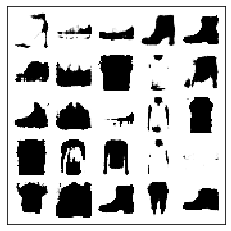

In [ ]:
# Sample data from the trained generative model to see if it
# roughly matches the data.

def sigmoid(x):
  # Maps logits to probabilities.
  return 0.5 * (torch.tanh(x) + 1.0)

sampled_zs = diag_gaussian_samples(torch.zeros(latent_dimension), torch.ones(latent_dimension), 25)    # TODO: Sample from prior on z.
bernoulli_means = sigmoid(decoder_net(sampled_zs).detach()) # TODO: Get logits, and map them to probabilities. Don't forget to .detach()
plot_images(bernoulli_means)

## 3.5 [4pts]

Another way to examine a latent variable model with continuous latent variables is to interpolate between the latent representations of two points. Here we will encode 3 pairs of data points with different classes. Then we will linearly interpolate between the mean vectors of their encodings. We will plot the generative distributions along the linear interpolation.


1.   First, write a function which takes two points $z_a$ and $z_b$, and a value $\alpha \in [0,1]$, and outputs the linear interpolation $z_\alpha = \alpha z_a + (1-\alpha)z_b$.
2.  Sample 3 pairs of images, each having a different class.
3.  Encode the data in each pair, and take the mean vectors
4.  Linearly interpolate between these mean vectors
5.  At 10 equally-space points along the interpolation, plot the Bernoulli means $p(x|z_\alpha)$.
6.  Concatenate these plots into one figure.

In [ ]:
def plot_interp(ix1, ix2):
    left_z = recognition_net(torch.tensor(train_images[ix1, :]).to(torch.float32))[0].detach()
    right_z = recognition_net(torch.tensor(train_images[ix2, :]).to(torch.float32))[0].detach()

    bernoulli_means = torch.zeros(10, 784)
    w = 0.0
    for i in  range(10):
        interp_zs = left_z * w  + right_z * (1 - w) # TODO: Linearly interpolate between left_z and right_z.  Feel free to use a for loop. You don't have to use interp_weights, but they might be helpful
        bernoulli_means[i] = sigmoid(decoder_net(interp_zs).detach())  # TODO: 
        w += 0.1
    plot_images(bernoulli_means)

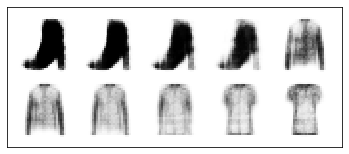

In [ ]:
plot_interp(3, 11)

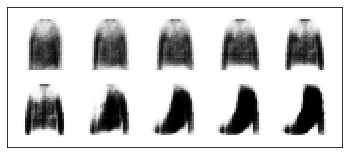

In [ ]:
plot_interp(11, 22)

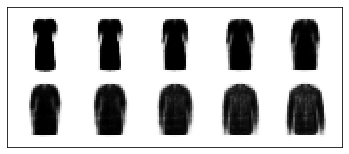

In [ ]:
plot_interp(32, 334)